# ENN583 Week 10 - Instance Segmentation

This week's practical will explore how you can use a pretrained instance segmentation model from PyTorch -- a model that combines both object detection and segmentation!

In particular, you'll use:
* [Mask R-CNN](https://arxiv.org/abs/1703.06870) -- one of the classic instance segmentation networks that builds off Faster R-CNN


# Import necessary libraries

In [12]:
from torchvision.io.image import read_image
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights, fcos_resnet50_fpn, FCOS_ResNet50_FPN_Weights, retinanet_resnet50_fpn_v2, RetinaNet_ResNet50_FPN_V2_Weights
from torchvision.models.detection import maskrcnn_resnet50_fpn_v2, MaskRCNN_ResNet50_FPN_V2_Weights

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from torchvision.transforms.functional import to_pil_image
import torchvision

import torch

from PIL import Image

from colormap import sample_colors

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import numpy as np

import glob

# Load the model from PyTorch

PyTorch has a number of pre-trained models available, including object detectors trained on COCO! 

You can see these [here](https://pytorch.org/vision/main/models.html#object-detection-instance-segmentation-and-person-keypoint-detection).

As mentioned, we be testing Mask R-CNN. At the above link, you can again see the mAP and GFLOPS of Mask-RCNN -- how does it compare to the models we tested last week: Faster R-CNN, FCOS and RetinaNet?

Below, we have built off the pytorch example code to visualise how to use an object detector. Similar to last week, note the key steps:
1. Initialise the model, load the weights and set into 'eval' mode
    * Note how we need to set a box_score_thresh -- this is the minimum confidence threshold for a detection to be valid. Let's start with this low, and we can always filter detections later
2. Load the data transforms necessary -- these typically ensure the image is the correct size and is normalized
3. Preprocess the data using the data transform -- pretty self-explanatory
4. Test the data with the model

We're printing the output from the object detector -- how is it describing detections as an output? Can you recognise the different elements of the detection? How is the bounding box parameterised?

In [22]:
img = read_image("images/coco/000000017029.jpg")

# Step 1: Initialize model with the best available weights
weights_mrcnn = MaskRCNN_ResNet50_FPN_V2_Weights.DEFAULT
mrcnn = maskrcnn_resnet50_fpn_v2(weights=weights_mrcnn, box_score_thresh=0.2)
mrcnn.eval()

# Step 2: Initialize the inference transforms
preprocess = weights_mrcnn.transforms()

# Step 3: Apply inference preprocessing transforms
batch = [preprocess(img)]

# Step 4: Use the model and visualize the prediction
prediction = mrcnn(batch)[0]

print(prediction)

{'boxes': tensor([[1.5453e+02, 1.1190e+02, 4.0736e+02, 5.3603e+02],
        [3.1539e+02, 7.7331e+01, 4.1463e+02, 1.2551e+02],
        [3.9750e+01, 2.0328e+01, 5.5725e+02, 1.7165e+02],
        [2.9941e+02, 1.9786e+01, 5.6110e+02, 1.7267e+02],
        [1.2046e-01, 4.5009e+01, 2.0277e+01, 8.9492e+01],
        [5.4820e+01, 7.3059e+01, 2.2802e+02, 1.7340e+02]],
       grad_fn=<StackBackward0>), 'labels': tensor([18, 34,  3,  3,  3,  3]), 'scores': tensor([0.9976, 0.9938, 0.9908, 0.9750, 0.9666, 0.9564],
       grad_fn=<IndexBackward0>), 'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],


        [[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],

## Step 3: Visualise the predictions

Note that our prediction is again a dictionary, but now with an extra field -- 'masks'! The data in this field describes the segmentation mask for each detection produced by the model. 

The value of those masks is “How likely is this pixel to belong to the predicted class?”. This means the value for each mask will range between 0 and 1. We want to create a boolean mask -- either a pixel belongs to the detected object or not. As a result, a natural way of converting those masks into boolean values is to threshold them with the 0.5 probability (one could also choose a different threshold).

Below, I've created a **draw_detections_mask** function that you can use to visualise results from the Pytorch detectors. This is the same as last week, but now if there is a 'masks' field in the prediction, it will also be drawn

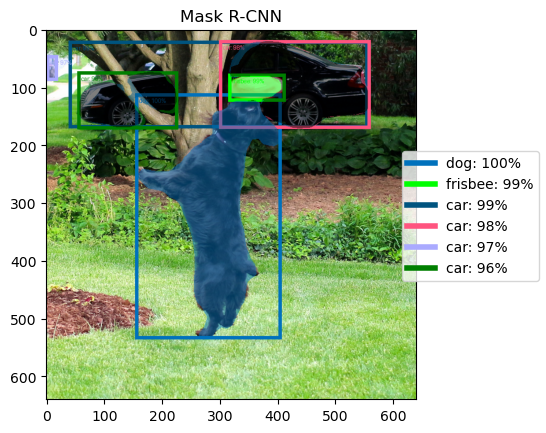

In [25]:
coco_categories = weights_mrcnn.meta["categories"]

def draw_detections_mask(img, prediction = None, detectorName = 'F-RCNN', mask_thresh = 0.5):
    if prediction != None:
        #extract the labels and scores -- combine these into text that can be printed on the image
        labels = [coco_categories[i] for i in prediction["labels"]]
        scores = [f'{int(100.*torch.round(s, decimals=2))}%' for s in prediction['scores']]
        print_txt = [f'{labels[i]}: {scores[i]}' for i in range(len(prediction['scores']))]
    
        # picks colors that are visually distinct to draw on the image
        color_list = sample_colors(len(scores), rgb = True)
        color_list_int = [(int(c[0]), int(c[1]), int(c[2])) for c in color_list]
    
        #creates a tensor image with the bboxes drawn on the image
        box = draw_bounding_boxes(img, boxes=prediction["boxes"],
                                  labels=print_txt,
                                  colors=color_list_int,
                                  width=6, font_size=50)
        
        if 'masks' in prediction.keys():
            box = draw_segmentation_masks(box, prediction['masks'].squeeze(1) >= mask_thresh, colors = color_list_int, alpha=0.5)
    
    else:
        #draw the raw image only
        box = img
    
    #put the image in format compatible with matplotlib
    box = box.numpy()
    box = np.swapaxes(box, 0, 1)
    box = np.swapaxes(box, 1, 2)
    
    #draw with matplotlib
    fig, ax = plt.subplots()
    ax.imshow(box)
    ax.set_title(detectorName)

    if prediction != None:
    #text is hard to read -- create a custom legend
        custom_lines = []
        for c in color_list_int:
            c_plt = (c[0]/255, c[1]/255, c[2]/255)
            custom_lines += [Line2D([0], [0], color = c_plt, lw = 4)]
        fig.legend(custom_lines, print_txt, loc = 'outside right center')
                            
    plt.show()
    
draw_detections_mask(img, prediction, 'Mask R-CNN', mask_thresh = 0.5)

**Note:** when there are multiple masks on top of each other, they will show up black -- see the car in the above example.

### Your turn: Try updating the mask_thresh value to be higher or lower and observe how it changes the mask.

# Testing over a set of images and extracting performance.

### Your turn:
Following the same process as the practical last week, test Mask R-CNN on the images and extract the following information:
1. Identify the TP and FN for class dog
2. Find the IoU of all TP for class dog
3. Identify a reasonable confidence threshold for TP predictions that can remove FP

**Your goal is to identify how the performance of Mask R-CNN compares with Faster R-CNN, RetinaNet and FCOS.**

Below, I have already loaded in the ground-truth labels and created a simple testing loop that finds the prediction for each image.

**Note: This should be the same code as last week! You will not be utilising the segmentation mask for performance evaluation, only the bounding boxes.**


In [18]:
import json

with open('dog_object_labels.json', 'r') as f:
    gt_labels = json.load(f)

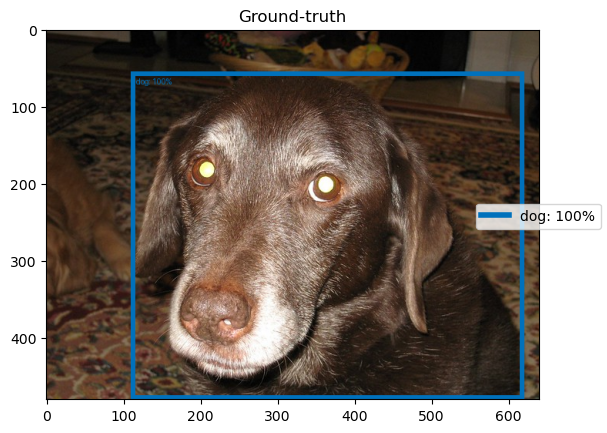

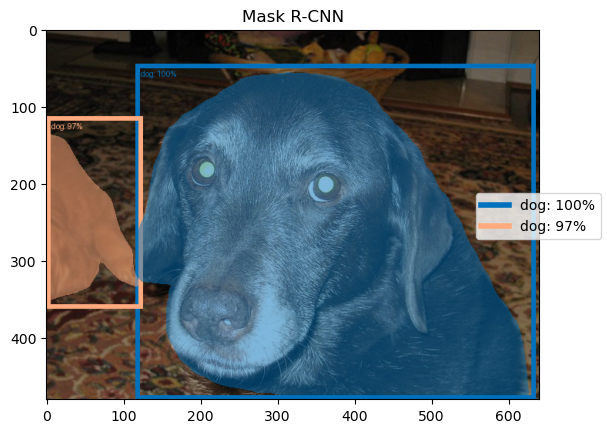

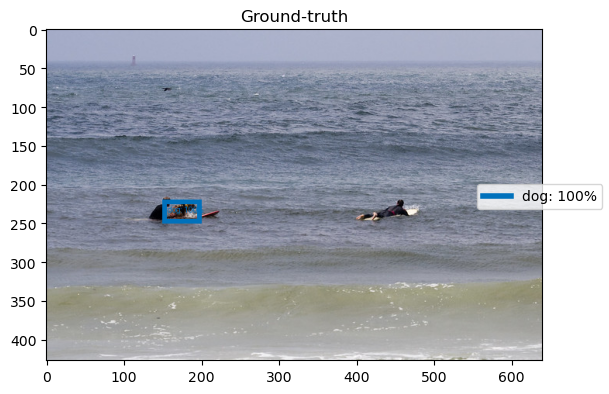

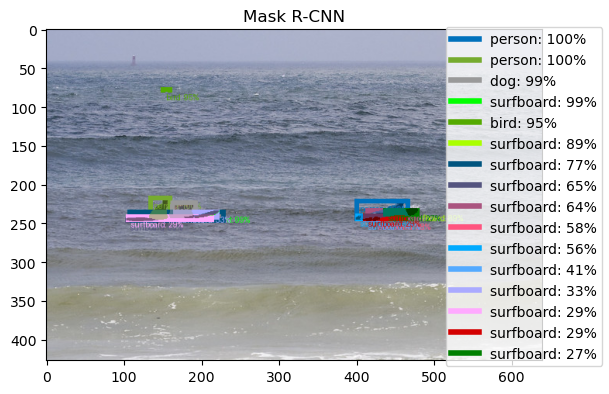

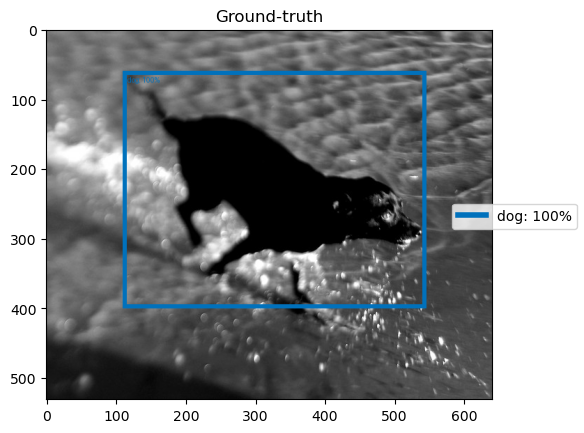

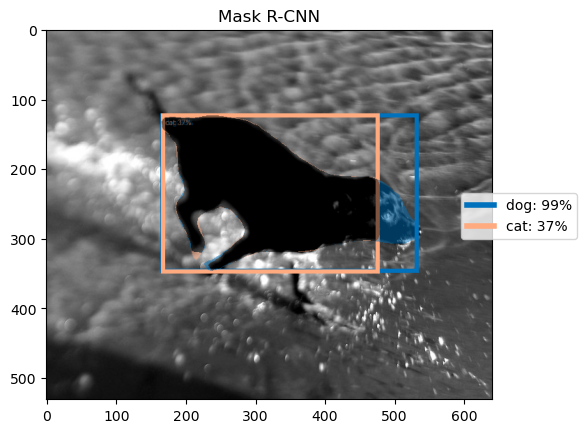

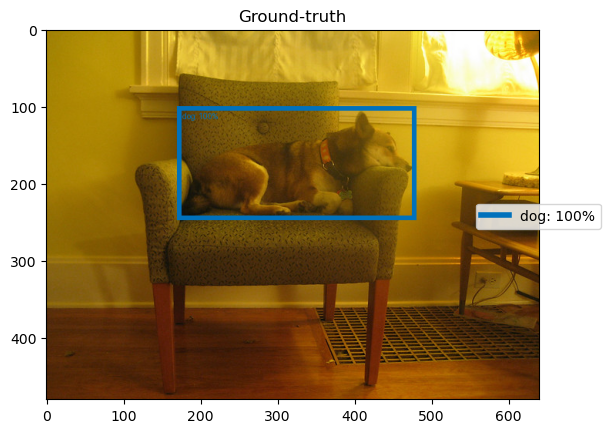

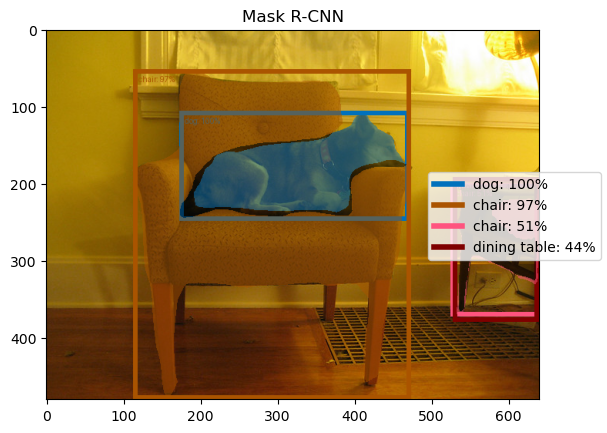

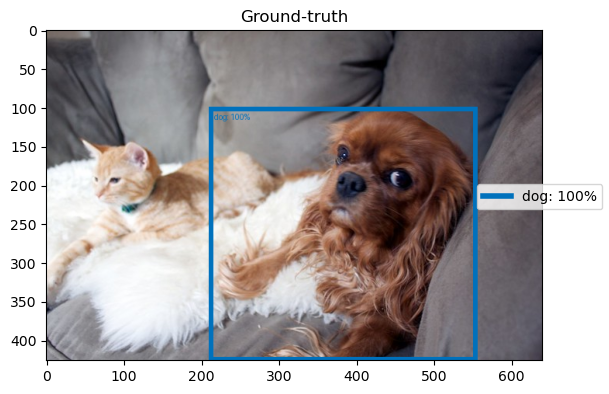

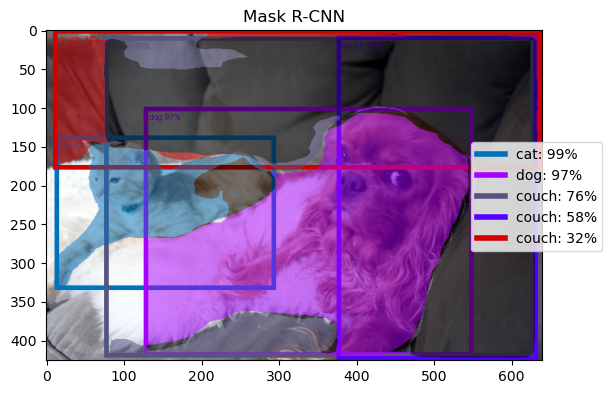

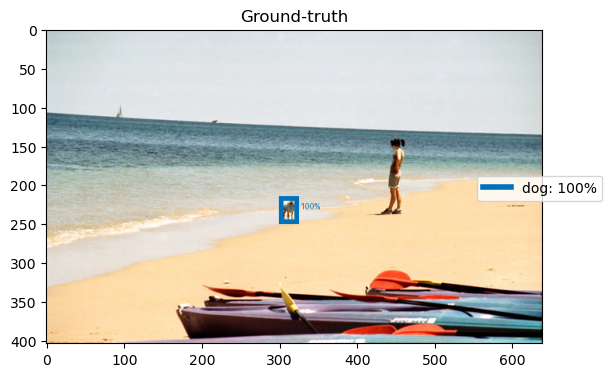

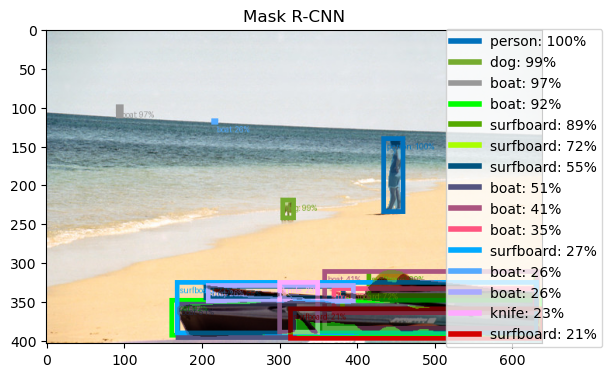

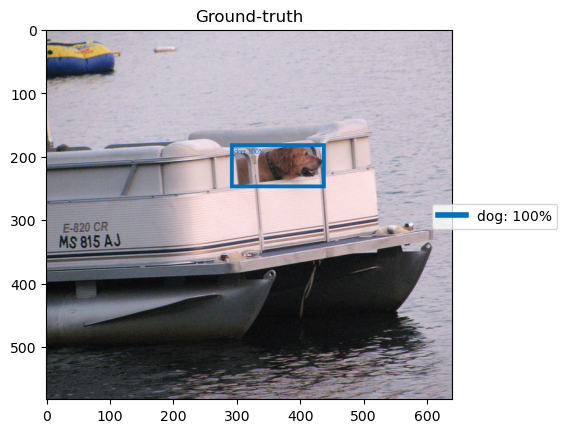

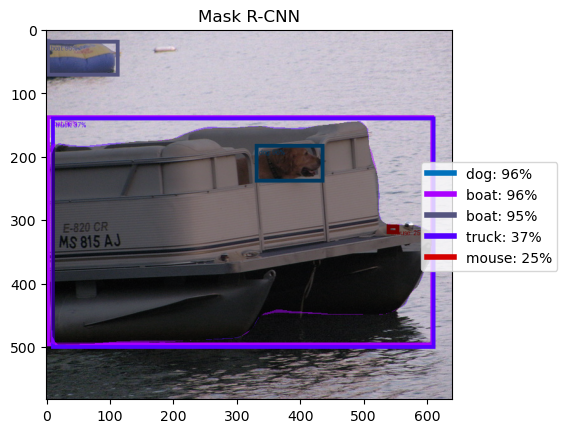

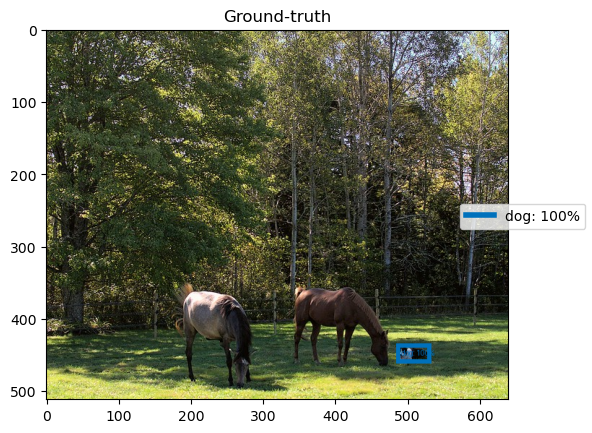

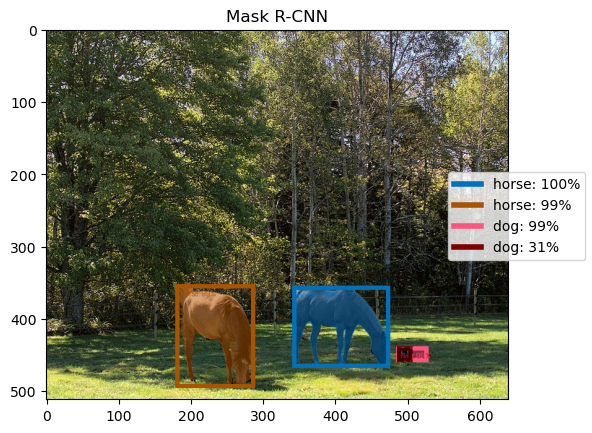

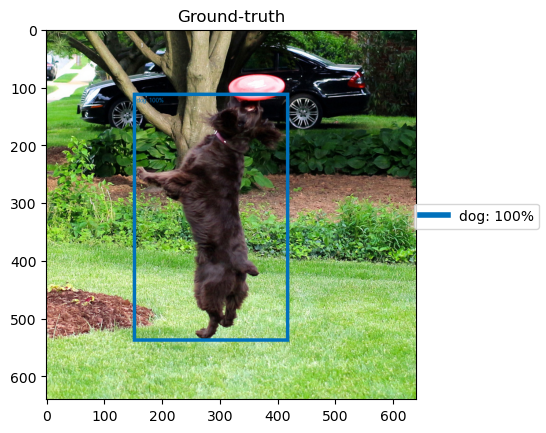

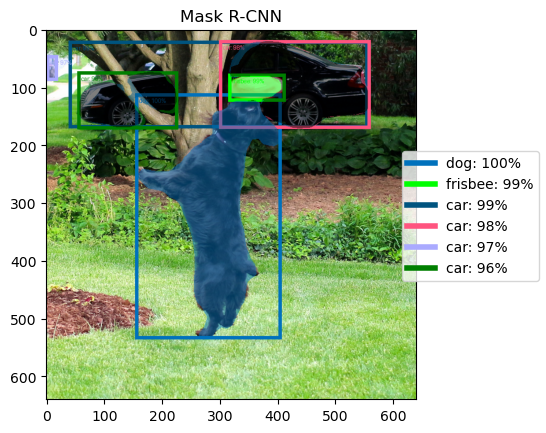

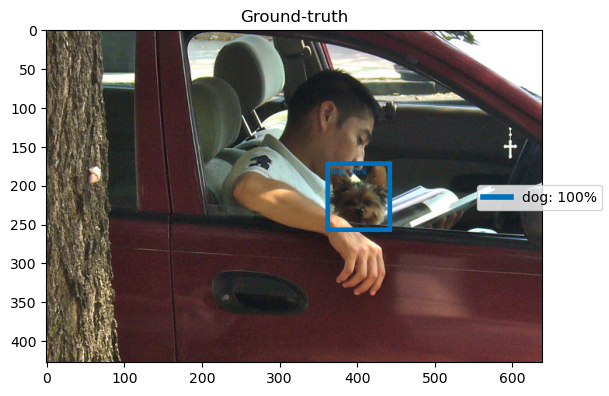

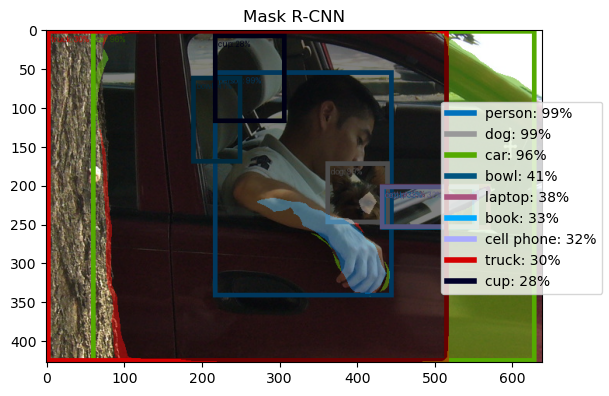

In [20]:
#for every image in the coco folder
for idx, file_name in enumerate(glob.glob('images/coco/*.jpg')):
    #read in the image
    img = read_image(file_name)
    
    #make a prediction
    with torch.no_grad():
        
        batch = [preprocess(img)]

        prediction = mrcnn(batch)[0]

   
    #draw the ground truth
    gt_bbox = gt_labels[file_name]
    #coco category 18 = dog
    ground_truth = {'scores': torch.Tensor([1]), 'labels': torch.Tensor([18]).int(), 'boxes': torch.Tensor([gt_bbox])}
    draw_detections_mask(img, ground_truth, 'Ground-truth')

    #draw the prediction
    draw_detections_mask(img, prediction, 'Mask R-CNN')

After you have extracted performance for Mask-RCNN, how does this compare to the detectors from Week 9?

Do you observe: 
- different numbers of TPs?
- different localisation qualities (IoU)?
- any differences in detector behaviour?

**Consider: How would you use this information to decide which detector to use?**

**Consider: Are there any benefits to using Mask R-CNN with a segmentation mask for the project compared to the other detectors?**

# Begin adapting the code to Project 2 data

In the remaining time for this tutorial, begin adapting this object detection evaluation code (from Week 9 and Week 10) to the Project 2 dataset. 

You will need to perform a performance evaluation for the project, and this is the perfect place to get started!